


# Chemical Encoding NN


  -Since the dataset is not linearly separable, the logistic regression algorithm is not suggested for the data. Here we implemented an normal neural network(NN) method.The general methodology is referenced by the tutorial codes.

  -picture of NN presentation and fomulas here

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>



# Load_chemicals

- The chemicals are incoded in SMILES based on ECFP4
- These functions to build a deep neural network for chemicals' solubility classification.

**After this segment you will be able to:**
- The chemical structure is in SMILES format.
- Use rdkit to calculate the fingerprint and map into a binary vector.


In [119]:
""" Import_packages"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import numpy as np
import time
# import h5py
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem

In [72]:
""" Read csv file and return it as a list"""

def read_csv(path):
    """ Read csv, return  panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df


In [73]:
"""load chemicals"""

def load_chemicals(path):
    
    SolubilityData = read_csv(path) # read csv
    
    chems=[] # variable to store the 
    
#     print("List loaded:\n") # view the list
#     print(SolubilityData)
    
    # change column names of 
    SolubilityData.rename(columns={ SolubilityData.columns[1]: "Solubility" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

#     chems = SolubilityData['SMILES'] # read columns
#     compounds =  SolubilityData['Compound ID']
#     solubilities = SolubilityData['measured log(solubility:mol/L)']
    
#     data = {"chems": chems,
#             "compounds": compounds,
#             "solubilities": solubilities,


data = load_chemicals("C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")
# data # show the input dataframe

In [74]:
fpix=AllChem.RDKFingerprint(data['SMILES'][0], 1, 1, fpSize=20)
fpix = [int(x) for x in list(fpix.ToBitString())]
print(fpix)
fpix=AllChem.RDKFingerprint(data['SMILES'][0], 2, 2, fpSize=20)
fpix = [int(x) for x in list(fpix.ToBitString())]
print(fpix)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


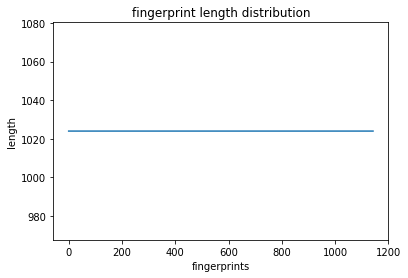

In [75]:
"""Convert SMILES into fingerprint"""
"""
RDKFingerprint from Chem:

Returns an RDKit topological fingerprint for a molecule

ARGUMENTS for RDKFingerprint:
    
        - mol: the molecule to use
    
        - minPath: (optional) minimum number of bonds to include in the subgraphs
          Defaults to 1.
    
        - maxPath: (optional) maximum number of bonds to include in the subgraphs
          Defaults to 7.
    
        - fpSize: (optional) number of bits in the fingerprint
          Defaults to 2048.
          
"""

def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH, MAX_PATH):
    tmp=[]
    length=[]
    fpix=AllChem.RDKFingerprint(chem[0], minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)
    fpix = [int(x) for x in list(fpix.ToBitString())]
    for i in range(1,len(chem)):
        tmp = AllChem.RDKFingerprint(chem[i], minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE) # convert SMILE to fingerprint    
        tmp = [int(x) for x in list(tmp.ToBitString())] # convert footprint object to binary vector
        length.append(len(tmp)) # append length of each fingerprint
        fpix=np.vstack((fpix,tmp)) # stack each fingerprint
    return length,fpix

# Test the function
minPath = 1 
maxPath = 5
fpSize = 1024
length,px = chemFP(data['SMILES'], fpSize, minPath, maxPath)

# plot the i nput fingerprint length distribution plot
plt.plot(np.squeeze(length))
plt.ylabel('length')
plt.xlabel('fingerprints')
plt.title("fingerprint length distribution" )
plt.show()

In [76]:
""" Visualize vector of binary chemical from minDepth_1 to maxDepth_5 """
px

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1]])

In [77]:
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

In [78]:
""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs


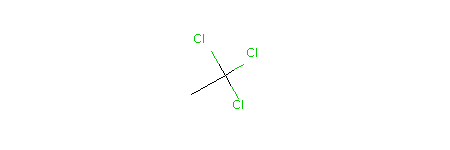

In [79]:
data['SMILES'][1]

In [80]:
""" Tranform the tensor into two dimentional vector """
depth = 4
train_y_b4=np.zeros((1,len(data['Solubility'])))
fpSize = 1024
tc = tensorChem(data['SMILES'],fpSize, depth)
print('The original vector shape:\n'+str(tc.shape))
train_x_flatten = tc.reshape(tc.shape[0], -1).T
print('The converted(flattened) vector shape:\n '+str(train_x_flatten.shape))
train_y_b4[0]=np.squeeze(data['Solubility'])
print('The solubility vector shape:\n '+str(train_y.shape))


(1144, 1024, 4)
The original vector shape:
(1144, 1024, 4)
The converted(flattened) vector shape:
 (4096, 1144)
The solubility vector shape:
 (1, 1144)


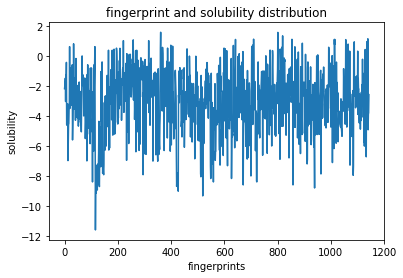

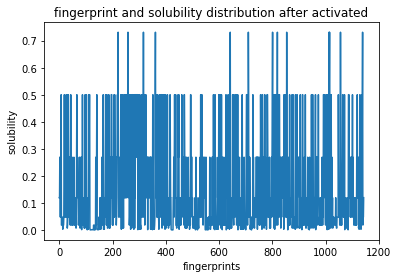

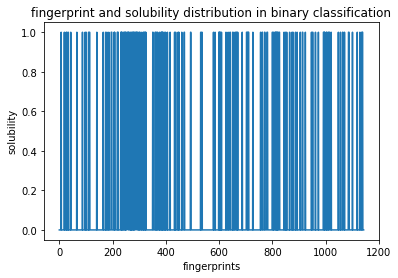

In [81]:
""" Reshape train_y into a vector range from 0 to 1 """
# plot the i nput fingerprint length distribution plot
plt.plot(np.squeeze(train_y_b4))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution" )
plt.show()
# convert train_y into a vector range from 0 to 1
train_y=np.zeros((1,len(data['Solubility'])))
for i in range(0,len(train_y_b4[0])):
    A,cache=sigmoid(int(train_y_b4[0][i]))
    train_y[0][i]=A

# plot the i nput fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution after activated" )
plt.show()


for i in range(0,len(train_y[0])):
    if (train_y[0][i]>=0.3):
        train_y[0][i]=1
    else:
        train_y[0][i]=0
    
# plot the i nput fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution in binary classification" )
plt.show()

Text(0,0.5,'fingerprint')

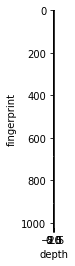

In [82]:
""" Visualize tensor vector """
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(tc[0,:,:])
plt.set_cmap('hot')
plt.xlabel('depth')
plt.ylabel('fingerprint')

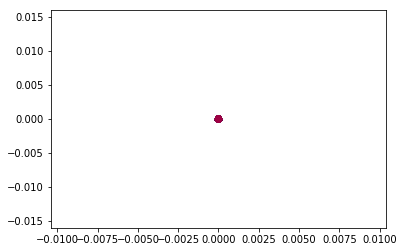

In [83]:
# Visualize the data:
plt.scatter(train_x_flatten[0],train_x_flatten[1], c=train_y[0], s=40, cmap=plt.cm.Spectral);
# Here we should add PCA#####################################################

### a) L-Layer NN Model 

**After this segment you will be able to:**
- Use non-linear units like ReLU to improve your model
- Build a deeper neural network (with more than 1 hidden layer)
- Implement an easy-to-use neural network class

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>

Codes based on Andrew N.g's model code

Implementing the $L$-layer Neural Net, we design a function that replicates(`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)




**Steps**:
- Use the functions you had previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [84]:
"""Activation functions"""

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [85]:
"""Init_parameters_deep""" 

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
        bl -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [86]:
"""Forward propagation and backward propagation"""

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)], parameters['b'+str(l)], activation='relu')
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation='sigmoid')
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL)))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m)*np.dot(dZ,cache[0].T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(cache[1].T,dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,activation='sigmoid')
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [87]:
"""update vectors W,b for gradient descent"""

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db"+str(l+1)]
    ### END CODE HERE ###
    return parameters

# b) Application

- In the segment, we will used the deep NN to train a model from the chemicals data
- In the next assignment, you will use these functions to build a deep neural network for solubility classification.

**After this assignment you will be able to:**

- Train a solubility classifier from chemicles(binary vector) and relervant solubility data
- Implement an easy-to-use classifier

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>

train_x_flatten: the binary vector of a chemicals list

train_y: the solubility feature of the vector


In [88]:
""" Define_NN_structures """
n_x=train_x_flatten.shape[0]    # fpsize  * 4(depth)
n_h = 7
n_y = 1
### CONSTANTS ###
layers_dims = [n_x, 20, n_h, 5, n_y] #  4-layer model

In [89]:
""" Centralization_and_standardlization(binary_classification) """

' Centralization_and_standardlization(binary_classification) '

In [106]:
""" Application """

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL,Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL,Y,caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters,grads,learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if  i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,costs

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.621480
Cost after iteration 200: 0.571985
Cost after iteration 300: 0.537425
Cost after iteration 400: 0.512959
Cost after iteration 500: 0.495389
Cost after iteration 600: 0.482596
Cost after iteration 700: 0.473163
Cost after iteration 800: 0.466128
Cost after iteration 900: 0.460827
Cost after iteration 1000: 0.456798
Cost after iteration 1100: 0.453711
Cost after iteration 1200: 0.451329
Cost after iteration 1300: 0.449480
Cost after iteration 1400: 0.448037
Cost after iteration 1500: 0.446906
Cost after iteration 1600: 0.446015
Cost after iteration 1700: 0.445310
Cost after iteration 1800: 0.444752
Cost after iteration 1900: 0.444308
Cost after iteration 2000: 0.443953
Cost after iteration 2100: 0.443670
Cost after iteration 2200: 0.443444
Cost after iteration 2300: 0.443262
Cost after iteration 2400: 0.443115


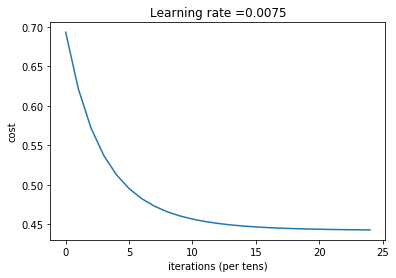

In [91]:
"""Train the model"""
parameters,costs = L_layer_model(train_x_flatten, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [95]:
"""Prediction based on training set"""


#Should be testing set########

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (non-significant: 0 / significant: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = L_model_forward(X,parameters)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [97]:
# Print accuracy
predictions = predict(parameters, train_x_flatten)
print ('Accuracy: %d' % float((np.dot(train_y,predictions.T) + np.dot(1-train_y,1-predictions.T))/float(train_y.size)*100) + '%')

Accuracy: 83%


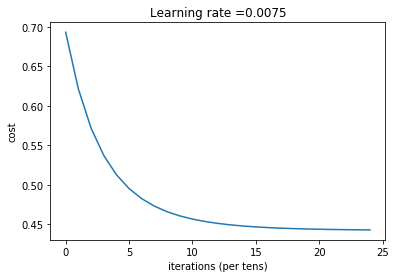

Accuracy for 1 hidden units: 83.82867132867133 %


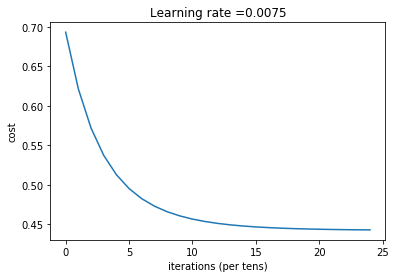

Accuracy for 2 hidden units: 83.82867132867133 %


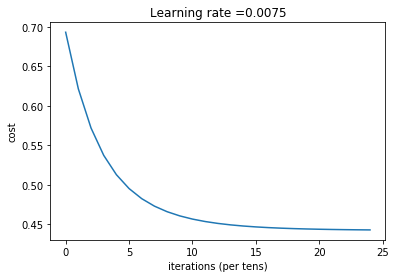

Accuracy for 3 hidden units: 83.82867132867133 %


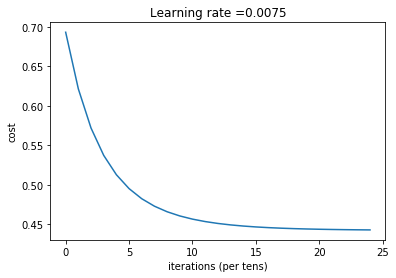

Accuracy for 4 hidden units: 83.82867132867133 %


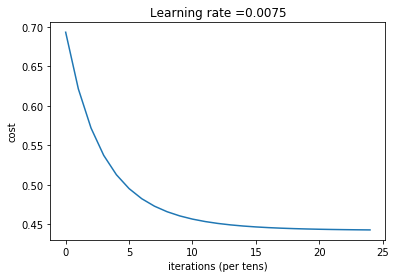

Accuracy for 5 hidden units: 83.82867132867133 %


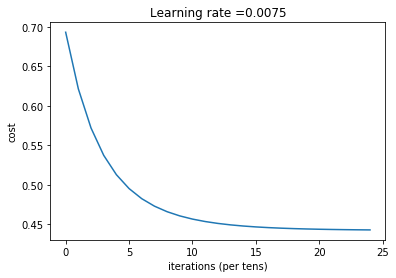

Accuracy for 20 hidden units: 83.82867132867133 %


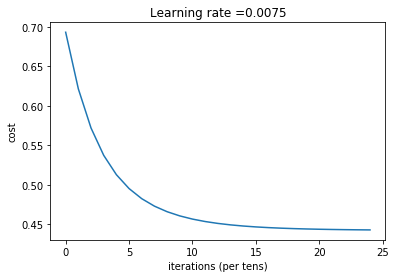

Accuracy for 50 hidden units: 83.82867132867133 %


In [107]:
# Tunning hidden layer size in hidden layer 2nd

hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

costs=[]

for i, n_h in enumerate(hidden_layer_sizes):
    layers_dims = [n_x, 20, n_h, 5, n_y] #  4-layers model with n_h hidden units
    parameters,costs = L_layer_model(train_x_flatten, train_y, layers_dims, num_iterations = 2500, print_cost = False)

    # Here we should add PCA#####################################################
    #plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters,train_x_flatten)
    accuracy = float((np.dot(train_y,predictions.T) + np.dot(1-train_y,1-predictions.T))/float(train_y.size)*100) 
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

In [109]:
Accuracy for 1 hidden units: 83.82867132867133 %

Accuracy for 2 hidden units: 83.82867132867133 %

Accuracy for 3 hidden units: 83.82867132867133 %

Accuracy for 4 hidden units: 83.82867132867133 %

Accuracy for 5 hidden units: 83.82867132867133 %

Accuracy for 20 hidden units: 83.82867132867133 %

Accuracy for 50 hidden units: 83.82867132867133 %

SyntaxError: invalid syntax (<ipython-input-109-031109efd209>, line 1)

learning rate is: 0.01


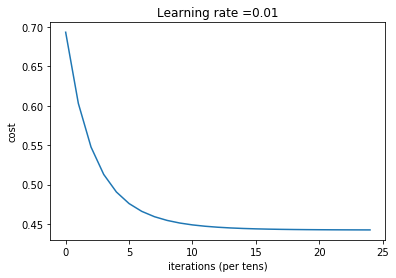

Time for learning rate0.01 : 130.51328468322754 %
Accuracy for learning rate0.01 : 83.82867132867133 %

-------------------------------------------------------

learning rate is: 0.001


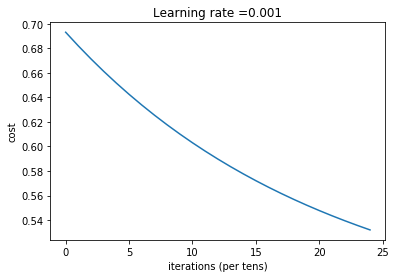

Time for learning rate0.001 : 133.12642455101013 %
Accuracy for learning rate0.001 : 83.82867132867133 %

-------------------------------------------------------



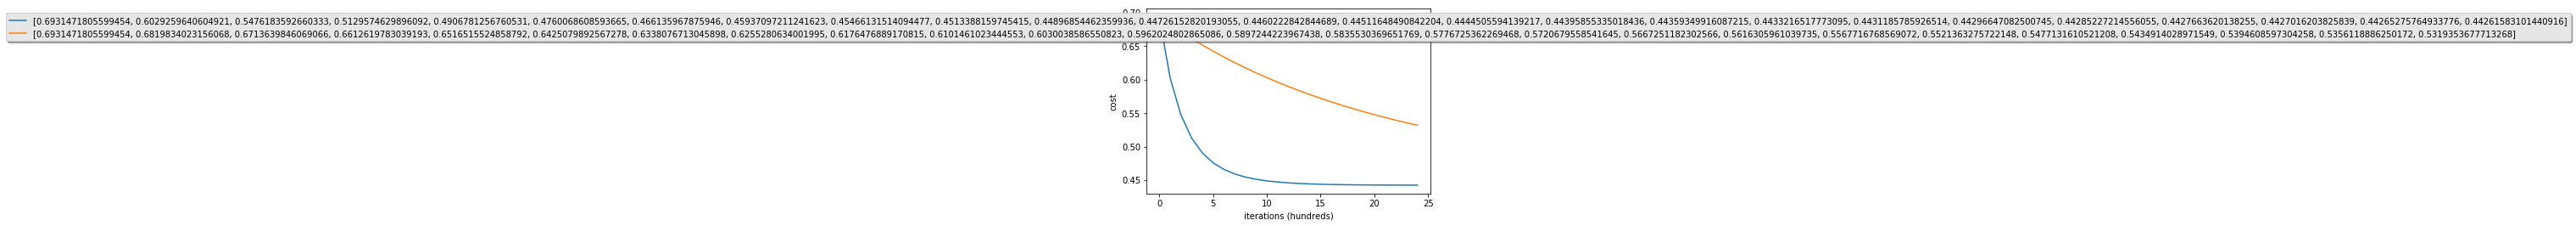

In [120]:
"""Tuning learning rate"""
#Try PyTOUCH########################################
learning_rates = [0.01, 0.001, 0.0001]
layers_dims = [n_x, 20, 1, 1, n_y]
costs_list=[]
for i in range(0,len(learning_rates)-1):
    print ("learning rate is: " + str(learning_rates[i]))
    start = time.time()
    parameters,costs = L_layer_model(train_x_flatten, train_y, layers_dims,learning_rate=learning_rates[i], num_iterations = 2500, print_cost = False)
    elapsed = (time.time() - start)
    print ("Time for learning rate{} : {} %".format(str(learning_rates[i]), elapsed))
    costs_list.append(costs)
    predictions = predict(parameters,train_x_flatten)
    accuracy = float((np.dot(train_y,predictions.T) + np.dot(1-train_y,1-predictions.T))/float(train_y.size)*100) 
    print ("Accuracy for learning rate{} : {} %".format(str(learning_rates[i]), accuracy))
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in range(0,len(learning_rates)-1):
    plt.plot(np.squeeze(costs_list[i]), label= str(costs_list[i]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()